# Load ads

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

# from housing_crawler.utils import save_file, get_file, get_grid_polygons_all_cities
from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.string_utils import remove_prefix, simplify_address, standardize_characters, capitalize_city_name, german_characters
from housing_crawler.utils import standardize_features, return_significative_coef


from config.config import ROOT_DIR
from housing_crawler.params import dict_city_number_wggesucht

In [2]:
ads_feat_df = get_processed_ads_table()
list(ads_feat_df.columns)

===> Loaded ads_OSM.csv locally


/home/carlo/code/chvieira2/housing_crawler/housing_crawler/utils.py:35: DtypeWarning: Columns (29,31,33,34,35,37,42,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path)


['id',
 'url',
 'commercial_landlord',
 'title',
 'price_euros',
 'size_sqm',
 'available_rooms',
 'capacity',
 'available_spots_wg',
 'male_flatmates',
 'female_flatmates',
 'diverse_flatmates',
 'published_on',
 'published_at',
 'address',
 'city',
 'crawler',
 'latitude',
 'longitude',
 'available_from',
 'available_to',
 'details_searched',
 'cold_rent_euros',
 'mandatory_costs_euros',
 'extra_costs_euros',
 'transfer_costs_euros',
 'deposit',
 'zip_code',
 'home_total_size',
 'smoking',
 'wg_possible',
 'building_type',
 'building_floor',
 'furniture',
 'kitchen',
 'heating',
 'public_transport_distance',
 'parking',
 'schufa_needed',
 'type_offer_simple',
 'min_age_flatmates',
 'max_age_flatmates',
 'gender_searched',
 'min_age_searched',
 'max_age_searched',
 'construction_year',
 'energy_certificate',
 'energy_usage',
 'energy_efficiency_class',
 'heating_energy_source',
 'number_languages',
 'internet_speed',
 'toilet',
 'internet_dsl',
 'internet_wlan',
 'internet_flatrate',


In [3]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

45

In [4]:
# Percentage missing values per column
(ads_feat_df.isnull().sum().sort_values(ascending=False)/len(ads_feat_df)*100)[0:30]

energy_usage                 98.375310
energy_efficiency_class      98.018710
toilet                       97.801231
energy_certificate           97.340689
construction_year            95.896698
heating_energy_source        94.740545
kitchen                      94.532662
internet_speed               93.310946
transfer_costs_euros         89.437915
heating                      85.860718
home_total_size              85.419365
max_age_flatmates            84.957224
smoking                      84.437515
min_age_flatmates            83.727513
extra_costs_euros            83.281362
parking                      81.643879
furniture                    79.632206
mandatory_costs_euros        76.171744
building_type                75.955865
public_transport_distance    75.077956
deposit                      74.588630
building_floor               73.131846
zip_code                     70.139922
languages_deutsch            70.085552
extras_keller                70.085552
extras_dachboden         

# Creating WG, single-room and multi-room dataframes

In [5]:
wg_df = ads_feat_df.query('type_offer_simple == "WG"').reset_index().drop(columns=['index'])

singleroom_df = ads_feat_df.query('type_offer_simple == "Single-room flat"').reset_index().drop(columns=['index'])

flathouse_df = ads_feat_df.query('(type_offer_simple == "Apartment")').reset_index().drop(columns=['index'])

# Linear model WG

In [6]:
wg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45931 entries, 0 to 45930
Columns: 143 entries, id to cos_day_week_int
dtypes: float64(117), int64(5), object(21)
memory usage: 50.1+ MB


In [7]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_euros'#'price_per_sqm'

selected_num_features = [
            'size_sqm',
#         'home_total_size',
#         'available_rooms',
        'capacity',
#         'available_spots_wg',

        'days_available',
#         'sin_published_at',
#         'cos_published_at',
        'sin_day_week_int',
        'cos_day_week_int',
    
# Values
#         'cold_rent_euros',
#         'mandatory_costs_euros',
#         'extra_costs_euros',
#         'deposit',
#         'transfer_costs_euros',
#         'price_per_sqm',

# Flatmates
        'male_flatmates',
        'female_flatmates',
        'diverse_flatmates',
#         'min_age_flatmates',
#         'max_age_flatmates',
    
# Person searched
        'min_age_searched',
        'max_age_searched',
    
# Details
    
        'smoking_numerical',
        'furniture_numerical',
#       'kitchen_numerical',
        'public_transport_distance',

    
# WG only
        'number_languages',
        
#         'internet_speed',
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            
        'rental_length_term',
    
# Person searched
        'gender_searched',
        'age_category_searched',
    
# Details
    
        'schufa_needed',
#         'wg_possible',
    
#         'smoking',
        'building_type',
        'building_floor',
#         'furniture',
#         'kitchen',
#         'heating',
#         'parking',
    
        'tv_kabel',
        'tv_satellit',
    
        'shower_type_badewanne',
        'shower_type_dusche',
    
        'floor_type_dielen',
        'floor_type_parkett',
        'floor_type_laminat',
        'floor_type_teppich',
        'floor_type_fliesen',
        'floor_type_pvc',
        'floor_type_fußbodenheizung',
    
        'extras_waschmaschine',
        'extras_spuelmaschine',
        'extras_terrasse',
        'extras_balkon',
        'extras_garten',
#         'extras_gartenmitbenutzung',
        'extras_keller',
        'extras_aufzug',
        'extras_haustiere',
        'extras_fahrradkeller',
        'extras_dachboden',
    
# WG only
        'languages_deutsch',
        'languages_englisch',
    
        'wg_type_studenten',
        'wg_type_keine_zweck',
        'wg_type_maenner',
        'wg_type_business',
        'wg_type_wohnheim',
        'wg_type_vegetarisch_vegan',
        'wg_type_alleinerziehende',
        'wg_type_funktionale',
        'wg_type_berufstaetigen',
        'wg_type_gemischte',
        'wg_type_mit_kindern',
        'wg_type_verbindung',
        'wg_type_lgbtqia',
        'wg_type_senioren',
        'wg_type_inklusive',
        'wg_type_wg_neugruendung',
    
        'internet_dsl',
        'internet_wlan',
        'internet_flatrate'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = wg_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45931 entries, 0 to 45930
Data columns (total 97 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_euros                     45931 non-null  float64
 1   size_sqm                        45931 non-null  float64
 2   capacity                        45931 non-null  float64
 3   days_available                  45931 non-null  int64  
 4   sin_day_week_int                45931 non-null  float64
 5   cos_day_week_int                45931 non-null  float64
 6   male_flatmates                  45931 non-null  float64
 7   female_flatmates                45931 non-null  int64  
 8   diverse_flatmates               45931 non-null  float64
 9   min_age_searched                13304 non-null  float64
 10  max_age_searched                13304 non-null  float64
 11  smoking_numerical               13304 non-null  float64
 12  furniture_numerical             

In [8]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(4635, 97)

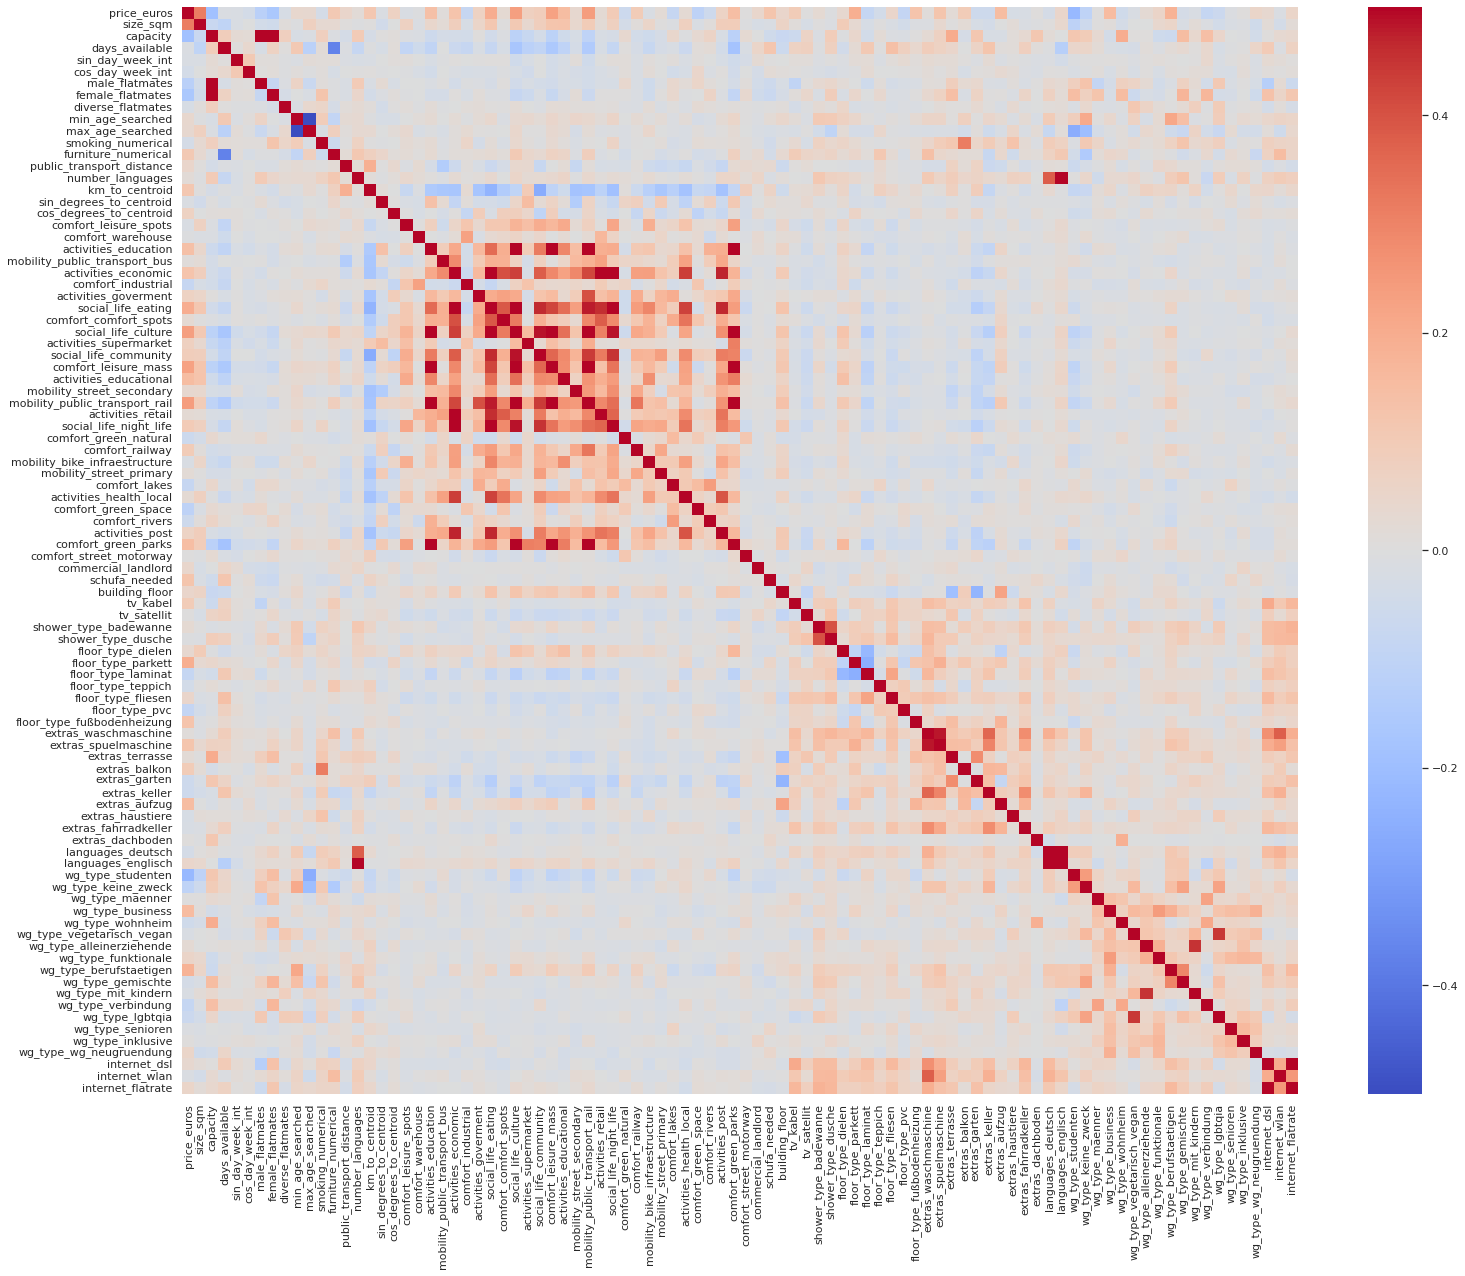

In [9]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 20))

data_corr = df_city.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [10]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
2517,social_life_culture,mobility_public_transport_rail,0.751344
3063,mobility_public_transport_rail,social_life_culture,0.751344
2049,activities_economic,social_life_eating,0.733511
2322,social_life_eating,activities_economic,0.733511
2787,comfort_leisure_mass,social_life_culture,0.696211
2514,social_life_culture,comfort_leisure_mass,0.696211
3245,social_life_night_life,social_life_eating,0.673155
2335,social_life_eating,social_life_night_life,0.673155
3066,mobility_public_transport_rail,comfort_leisure_mass,0.668780
2793,comfort_leisure_mass,mobility_public_transport_rail,0.668780


In [11]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
32,mobility_public_transport_rail,4.42
1,capacity,4.16
26,social_life_culture,3.79
24,social_life_eating,3.58
6,female_flatmates,3.00
21,activities_economic,2.98
29,comfort_leisure_mass,2.75
8,min_age_searched,2.55
9,max_age_searched,2.52
5,male_flatmates,2.44


In [12]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_euros   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     37.05
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:24:50   Log-Likelihood:                -28533.
No. Observations:                4635   AIC:                         5.737e+04
Df Residuals:                    4483   BIC:                         5.835e+04
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        412.3371     60.215      6.848      0.000     294.287     530.388
C(city)[Berlin]                        557.7340     59.064      9.443      0.000     441.940     673.528
C(city)[Bonn]                          471.0147     59.959      7.856      0.000     353.465     588.565
C(city)[Bremen]                        437.6174     59.791      7.319      0.000     320.398     554.836
C(city)[Darmstadt]                     460.1658     60.087      7.658      0.000     342.365     577.967
C(city)[Dresden]                       337.7999     59.767      5.652      0.000     220.627     454.972
C(city)[Frankfurt am Main]             545.5142     59.363      9.189      0.000     429.133     661.896
C(city)[Göttingen]                     396.0662     59.797      6.623      0.000     278.834     513.298
C(city)[Hamburg]                       564.6766     59.165      9.544      0.000     448.683     680.670
C(city)[Hannover]                      413.0714     59.753      6.913      0.000     295.926     530.217
C(city)[Heidelberg]                    472.8878     60.129      7.865      0.000     355.005     590.771
C(city)[Karlsruhe]                     429.2477     59.620      7.200      0.000     312.364     546.132
C(city)[Kiel]                          378.0732     60.621      6.237      0.000     259.225     496.921
C(city)[Köln]                          514.1892     59.179      8.689      0.000     398.169     630.210
C(city)[Leipzig]                       340.3947     59.164      5.753      0.000     224.404     456.386
C(city)[Mainz]                         460.9539     60.146      7.664      0.000     343.038     578.870
C(city)[Mannheim]                      423.2028     60.564      6.988      0.000     304.467     541.938
C(city)[München]                       676.8877     59.215     11.431      0.000     560.798     792.978
C(city)[Münster]                       407.5545     59.985      6.794      0.000     289.954     525.155
C(city)[Nürnberg]                      434.6917     60.242      7.216      0.000     316.588     552.796
C(city)[Regensburg]                    415.9472     60.366      6.890      0.000     297.600     534.294
C(city)[Stuttgart]                     528.1236     59.139      8.930      0.000     412.183     644.064
C(city)[Tübingen]                      478.4252     61.852      7.735      0.000     357.165     599.685
C(city)[Würzburg]                      410.0159     60.273      6.803      0.000     291.851     528.180
C(commercial_landlord)[T.1.0]           38.9106     23.456      1.659      0.097      -7.075      84.897
C(rental_length_term)[T.<270days]        3.6817      8.656      0.425      0.671     -13.288      20.651
C(rental_length_term)[T.<365days]     

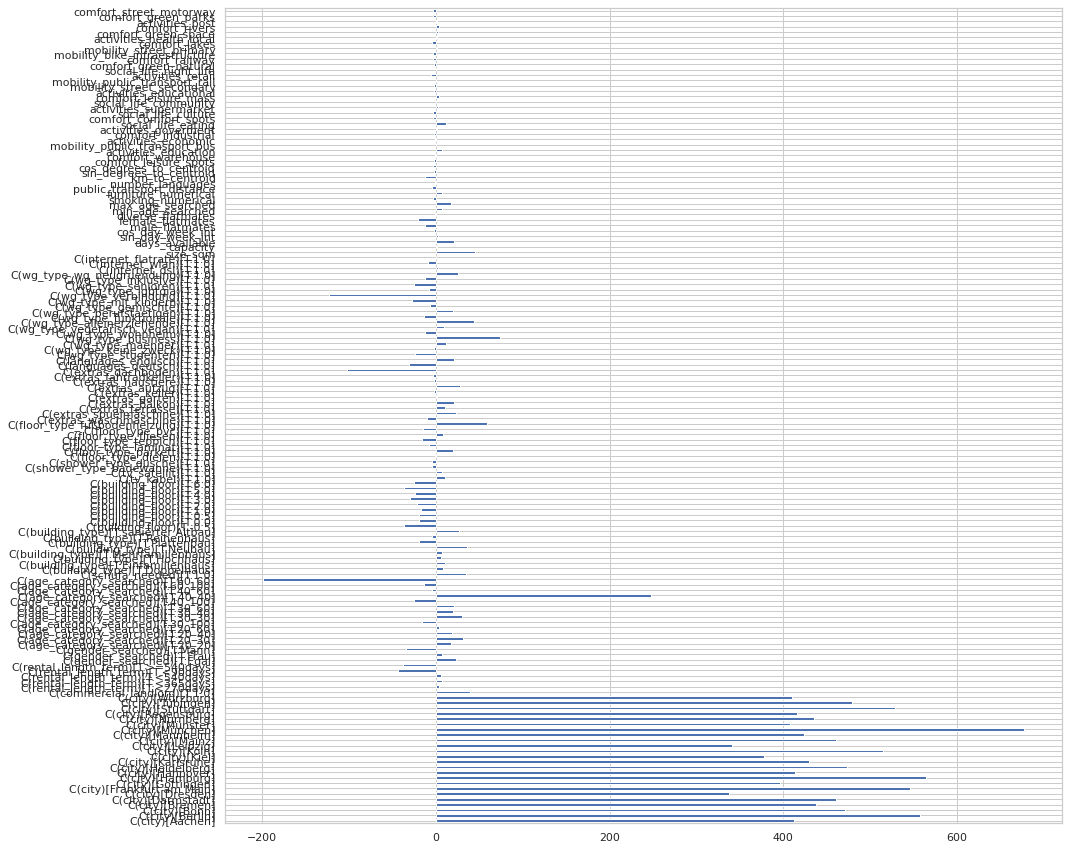

In [13]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 114.0910716582666
RMSE base model: 171.06320062141725


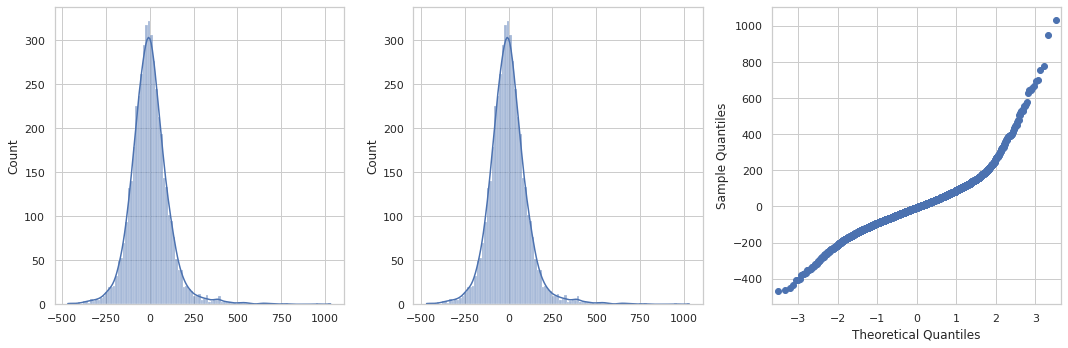

In [14]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_euros'])]*len(y_pred)
y_true = df_city['price_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

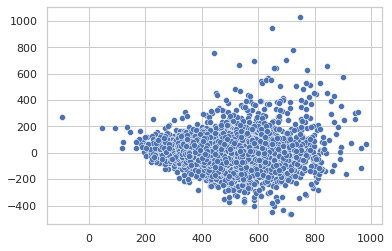

In [15]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                            p_value        coef
variable                                                       
C(city)[München]                       7.551594e-30  676.887745
C(city)[Hamburg]                       2.190574e-21  564.676584
C(city)[Berlin]                        5.669131e-21  557.733987
C(city)[Frankfurt am Main]             5.904625e-20  545.514168
C(city)[Stuttgart]                     6.086416e-19  528.123624
C(city)[Köln]                          5.062915e-18  514.189150
C(city)[Tübingen]                      1.268368e-14  478.425227
C(city)[Heidelberg]                    4.609023e-15  472.887769
C(city)[Bonn]                          4.944915e-15  471.014746
C(city)[Mainz]                         2.196904e-14  460.953871
C(city)[Darmstadt]                     2.294083e-14  460.165845
C(city)[Bremen]                        2.941530e-13  437.617394
C(city)[Nürnberg]                      6.267173e-13  434.691732
C(city)[Karlsruhe]                     7

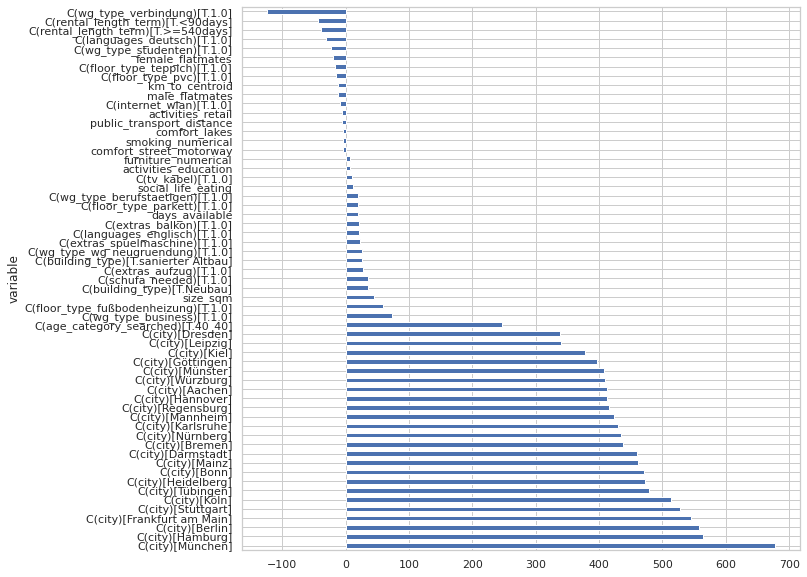

In [16]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Apartment

In [20]:
flathouse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8671 entries, 0 to 8670
Columns: 143 entries, id to cos_day_week_int
dtypes: float64(117), int64(5), object(21)
memory usage: 9.5+ MB


In [21]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_euros'

selected_num_features = [
    'size_sqm',
#             'days_available',
            'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

#             'building_floor',
#             'public_transport_distance',
#             'home_total_size',
            'furniture_numerical',
            'kitchen_numerical',
            'smoking_numerical',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
            'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
#             'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
#             'gender_searched',
                         
#             'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = flathouse_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8671 entries, 0 to 8670
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_euros                     8671 non-null   float64
 1   size_sqm                        8671 non-null   float64
 2   available_rooms                 8671 non-null   float64
 3   transfer_costs_euros            984 non-null    float64
 4   furniture_numerical             3003 non-null   float64
 5   kitchen_numerical               3003 non-null   float64
 6   smoking_numerical               3003 non-null   float64
 7   km_to_centroid                  4188 non-null   float64
 8   sin_degrees_to_centroid         4188 non-null   float64
 9   cos_degrees_to_centroid         4188 non-null   float64
 10  comfort_leisure_spots           4188 non-null   float64
 11  comfort_warehouse               4188 non-null   float64
 12  activities_education            41

In [22]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(429, 57)

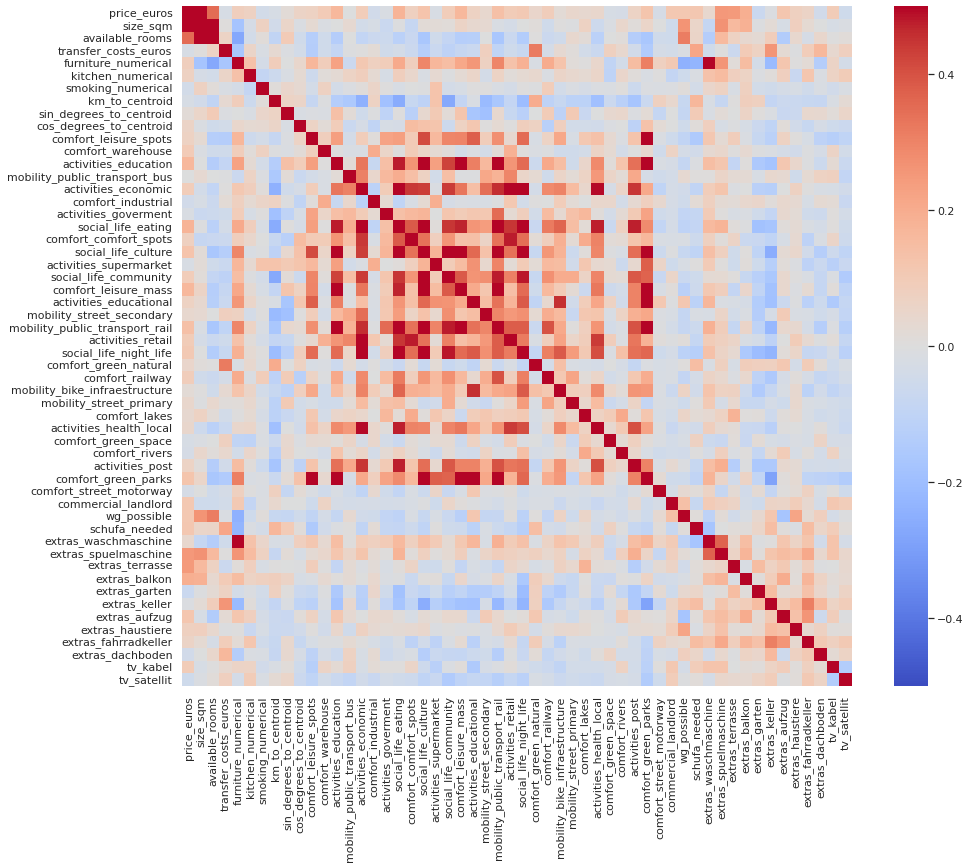

In [23]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [24]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
773,activities_economic,social_life_eating,0.752852
932,social_life_eating,activities_economic,0.752852
1051,social_life_culture,mobility_public_transport_rail,0.715641
1369,mobility_public_transport_rail,social_life_culture,0.715641
2017,comfort_green_parks,social_life_culture,0.714547
1063,social_life_culture,comfort_green_parks,0.714547
945,social_life_eating,social_life_night_life,0.706200
1475,social_life_night_life,social_life_eating,0.706200
2023,comfort_green_parks,mobility_public_transport_rail,0.693205
1387,mobility_public_transport_rail,comfort_green_parks,0.693205


In [25]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
24,mobility_public_transport_rail,4.98
16,social_life_eating,4.47
18,social_life_culture,4.40
36,comfort_green_parks,4.23
13,activities_economic,3.85
26,social_life_night_life,3.23
21,comfort_leisure_mass,3.14
11,activities_education,2.96
25,activities_retail,2.41
1,available_rooms,2.27


In [26]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_euros   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     6.745
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           2.49e-38
Time:                        01:25:56   Log-Likelihood:                -3001.4
No. Observations:                 429   AIC:                             6181.
Df Residuals:                     340   BIC:                             6542.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        857.3617    113.365      7.563      0.000     634.377    1080.346
C(city)[Berlin]                       1091.9544     95.792     11.399      0.000     903.534    1280.374
C(city)[Bonn]                          883.1956    140.228      6.298      0.000     607.372    1159.019
C(city)[Bremen]                        787.2576    161.442      4.876      0.000     469.706    1104.809
C(city)[Darmstadt]                    1238.2346    150.377      8.234      0.000     942.448    1534.021
C(city)[Dresden]                       759.8872    109.148      6.962      0.000     545.196     974.578
C(city)[Frankfurt am Main]            1132.2415    102.229     11.076      0.000     931.161    1333.322
C(city)[Göttingen]                     875.9353    175.045      5.004      0.000     531.629    1220.242
C(city)[Hamburg]                      1271.9332     98.415     12.924      0.000    1078.355    1465.511
C(city)[Hannover]                      990.2958    109.568      9.038      0.000     774.779    1205.812
C(city)[Heidelberg]                    929.2219    239.846      3.874      0.000     457.453    1400.991
C(city)[Karlsruhe]                     929.4909    156.216      5.950      0.000     622.219    1236.763
C(city)[Kiel]                          763.4519    158.776      4.808      0.000     451.145    1075.759
C(city)[Köln]                         1022.5916     95.493     10.709      0.000     834.760    1210.423
C(city)[Leipzig]                       749.9247    120.527      6.222      0.000     512.852     986.997
C(city)[Mainz]                         915.9663    163.284      5.610      0.000     594.792    1237.140
C(city)[Mannheim]                      862.3658    153.702      5.611      0.000     560.039    1164.692
C(city)[München]                      1305.4987     94.376     13.833      0.000    1119.864    1491.134
C(city)[Münster]                       663.9160    154.958      4.284      0.000     359.118     968.714
C(city)[Nürnberg]                      887.2767    130.239      6.813      0.000     631.101    1143.452
C(city)[Regensburg]                    947.6686    141.849      6.681      0.000     668.657    1226.680
C(city)[Stuttgart]                    1154.8221    104.943     11.004      0.000     948.403    1361.242
C(city)[Tübingen]                      951.1708    246.126      3.865      0.000     467.049    1435.293
C(city)[Würzburg]                      998.6782    152.991      6.528      0.000     697.751    1299.606
C(commercial_landlord)[T.1.0]          265.8267    114.394      2.324      0.021      40.817     490.837
C(rental_length_term)[T.<270days]      -21.3868     81.396     -0.263      0.793    -181.490     138.716
C(rental_length_term)[T.<365days]     

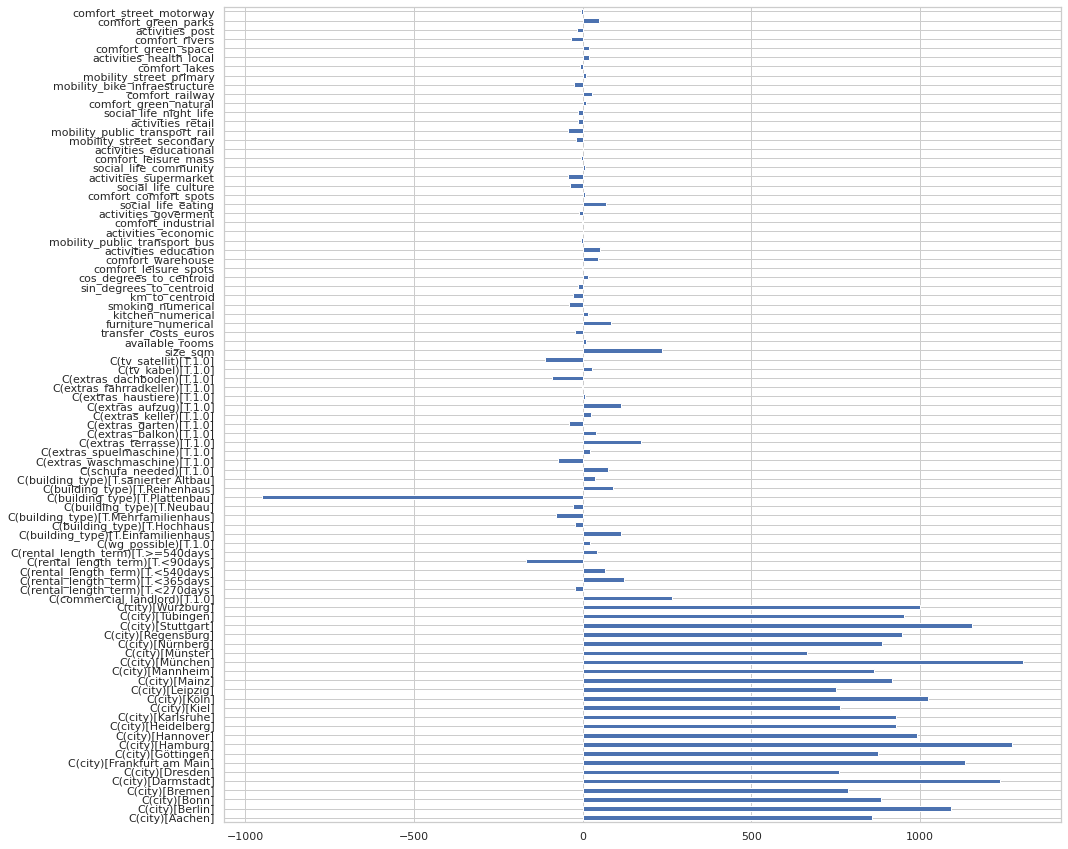

In [27]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 264.3932634560795
RMSE base model: 438.1156933527993


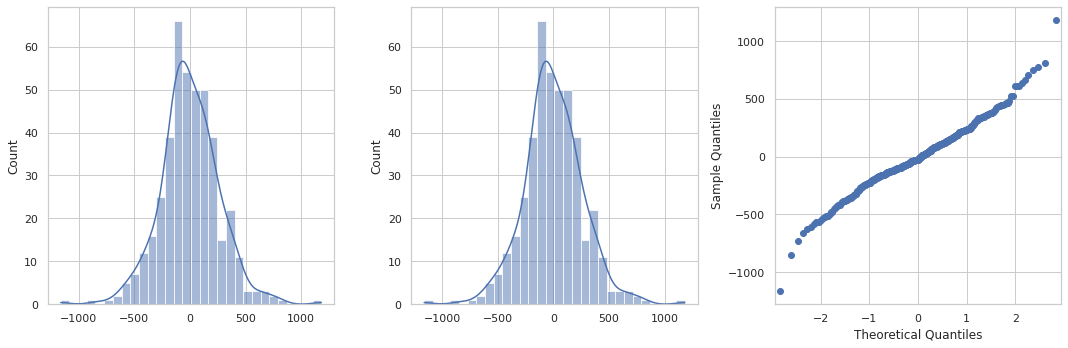

In [28]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_euros'])]*len(y_pred)
y_true = df_city['price_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

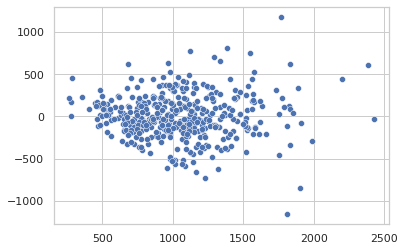

In [29]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                       p_value         coef
variable                                                   
C(city)[München]                  7.801710e-35  1305.498694
C(city)[Hamburg]                  2.340274e-31  1271.933171
C(city)[Darmstadt]                3.929657e-15  1238.234613
C(city)[Stuttgart]                2.691077e-24  1154.822082
C(city)[Frankfurt am Main]        1.500594e-24  1132.241541
C(city)[Berlin]                   1.036818e-25  1091.954436
C(city)[Köln]                     2.977307e-23  1022.591607
C(city)[Würzburg]                 2.429765e-10   998.678174
C(city)[Hannover]                 1.230059e-17   990.295837
C(city)[Tübingen]                 1.332852e-04   951.170805
C(city)[Regensburg]               9.722045e-11   947.668592
C(city)[Karlsruhe]                6.668111e-09   929.490891
C(city)[Heidelberg]               1.283132e-04   929.221912
C(city)[Mainz]                    4.205945e-08   915.966300
C(city)[Nürnberg]                 4.3644

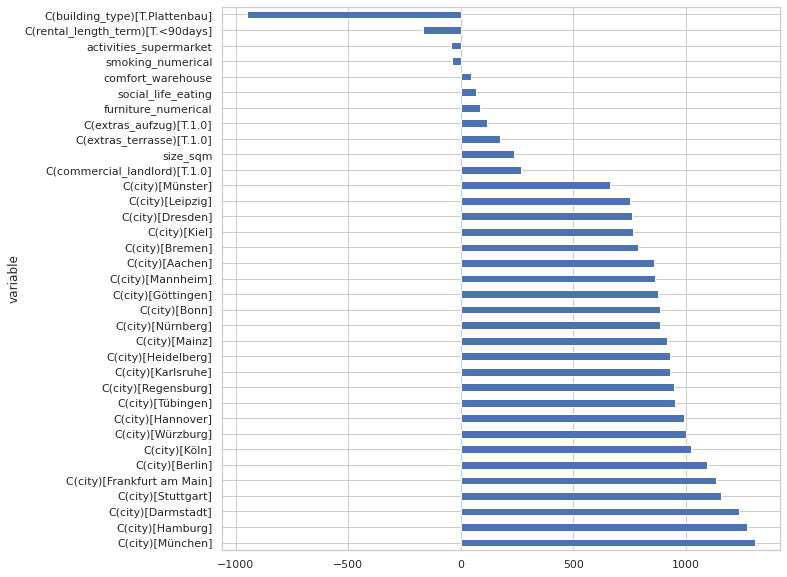

In [30]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Single-room flats

In [34]:
singleroom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7933 entries, 0 to 7932
Columns: 143 entries, id to cos_day_week_int
dtypes: float64(117), int64(5), object(21)
memory usage: 8.7+ MB


In [35]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_euros'

selected_num_features = [
    'size_sqm',
#             'days_available',
#             'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

            'building_floor',
#             'public_transport_distance',
#             'home_total_size',
            'furniture_numerical',
            'kitchen_numerical',
#             'smoking_numerical',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
#             'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
#             'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
            'gender_searched',
                         
            'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = singleroom_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7933 entries, 0 to 7932
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_euros                     7933 non-null   float64
 1   size_sqm                        7933 non-null   float64
 2   transfer_costs_euros            856 non-null    float64
 3   building_floor                  2120 non-null   float64
 4   furniture_numerical             2400 non-null   float64
 5   kitchen_numerical               2400 non-null   float64
 6   km_to_centroid                  3894 non-null   float64
 7   sin_degrees_to_centroid         3894 non-null   float64
 8   cos_degrees_to_centroid         3894 non-null   float64
 9   comfort_leisure_spots           3894 non-null   float64
 10  comfort_warehouse               3894 non-null   float64
 11  activities_education            3894 non-null   float64
 12  mobility_public_transport_bus   38

In [36]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(325, 57)

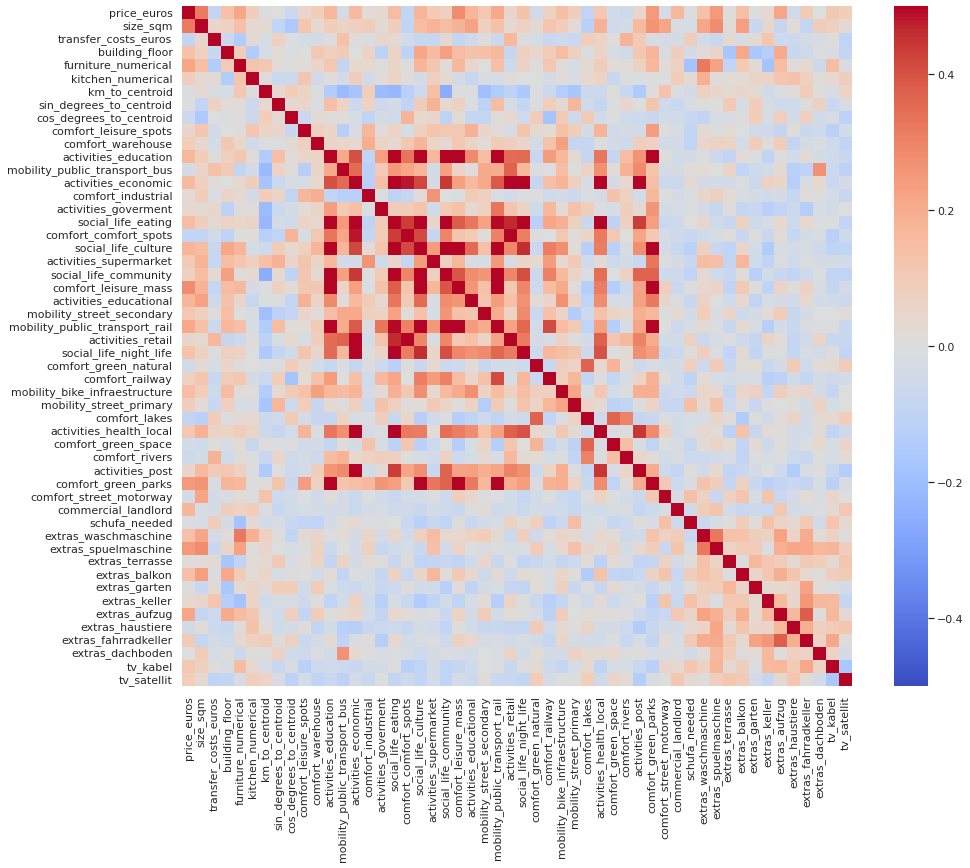

In [37]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [38]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
960,social_life_culture,mobility_public_transport_rail,0.831712
1266,mobility_public_transport_rail,social_life_culture,0.831712
596,activities_education,mobility_public_transport_rail,0.770230
1259,mobility_public_transport_rail,activities_education,0.770230
590,activities_education,social_life_culture,0.747084
947,social_life_culture,activities_education,0.747084
858,social_life_eating,social_life_night_life,0.724893
1368,social_life_night_life,social_life_eating,0.724893
1110,comfort_leisure_mass,social_life_culture,0.711432
957,social_life_culture,comfort_leisure_mass,0.711432


In [39]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
17,social_life_culture,7.63
23,mobility_public_transport_rail,6.87
15,social_life_eating,4.63
10,activities_education,4.58
35,comfort_green_parks,4.13
20,comfort_leisure_mass,3.54
12,activities_economic,2.89
25,social_life_night_life,2.61
19,social_life_community,2.44
24,activities_retail,2.31


In [40]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_euros   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     3.198
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           9.49e-13
Time:                        01:26:25   Log-Likelihood:                -2163.8
No. Observations:                 325   AIC:                             4506.
Df Residuals:                     236   BIC:                             4842.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        407.1966    102.132      3.987      0.000     205.990     608.403
C(city)[Berlin]                        686.2827     82.530      8.316      0.000     523.692     848.873
C(city)[Bonn]                          546.3640    176.238      3.100      0.002     199.163     893.565
C(city)[Bremen]                        687.8631    132.031      5.210      0.000     427.753     947.973
C(city)[Darmstadt]                     469.6099    153.289      3.064      0.002     167.621     771.599
C(city)[Dresden]                       521.1954    120.331      4.331      0.000     284.135     758.256
C(city)[Frankfurt am Main]             750.9936     82.343      9.120      0.000     588.773     913.214
C(city)[Göttingen]                     571.9545    138.174      4.139      0.000     299.742     844.167
C(city)[Hamburg]                       813.8223     99.480      8.181      0.000     617.840    1009.804
C(city)[Hannover]                      545.3792    116.795      4.670      0.000     315.286     775.473
C(city)[Heidelberg]                    632.0427    121.781      5.190      0.000     392.126     871.959
C(city)[Karlsruhe]                     631.8194    109.834      5.752      0.000     415.438     848.201
C(city)[Kiel]                          921.0455    260.147      3.540      0.000     408.539    1433.552
C(city)[Köln]                          740.9985     90.024      8.231      0.000     563.646     918.351
C(city)[Leipzig]                       526.6356    125.178      4.207      0.000     280.026     773.245
C(city)[Mainz]                         601.8090    120.821      4.981      0.000     363.784     839.834
C(city)[Mannheim]                      576.8317    104.124      5.540      0.000     371.700     781.963
C(city)[München]                       955.2262     82.323     11.603      0.000     793.045    1117.407
C(city)[Münster]                       391.0099    196.633      1.989      0.048       3.630     778.390
C(city)[Nürnberg]                      536.1703    117.992      4.544      0.000     303.719     768.622
C(city)[Regensburg]                    600.2125    126.903      4.730      0.000     350.204     850.221
C(city)[Stuttgart]                     679.2766     98.431      6.901      0.000     485.362     873.191
C(city)[Tübingen]                      705.9036    201.106      3.510      0.001     309.711    1102.096
C(city)[Würzburg]                      489.4296    121.334      4.034      0.000     250.394     728.465
C(commercial_landlord)[T.1.0]           36.5506    144.558      0.253      0.801    -248.239     321.340
C(rental_length_term)[T.<270days]      -95.3926     79.352     -1.202      0.231    -251.722      60.936
C(rental_length_term)[T.<365days]     

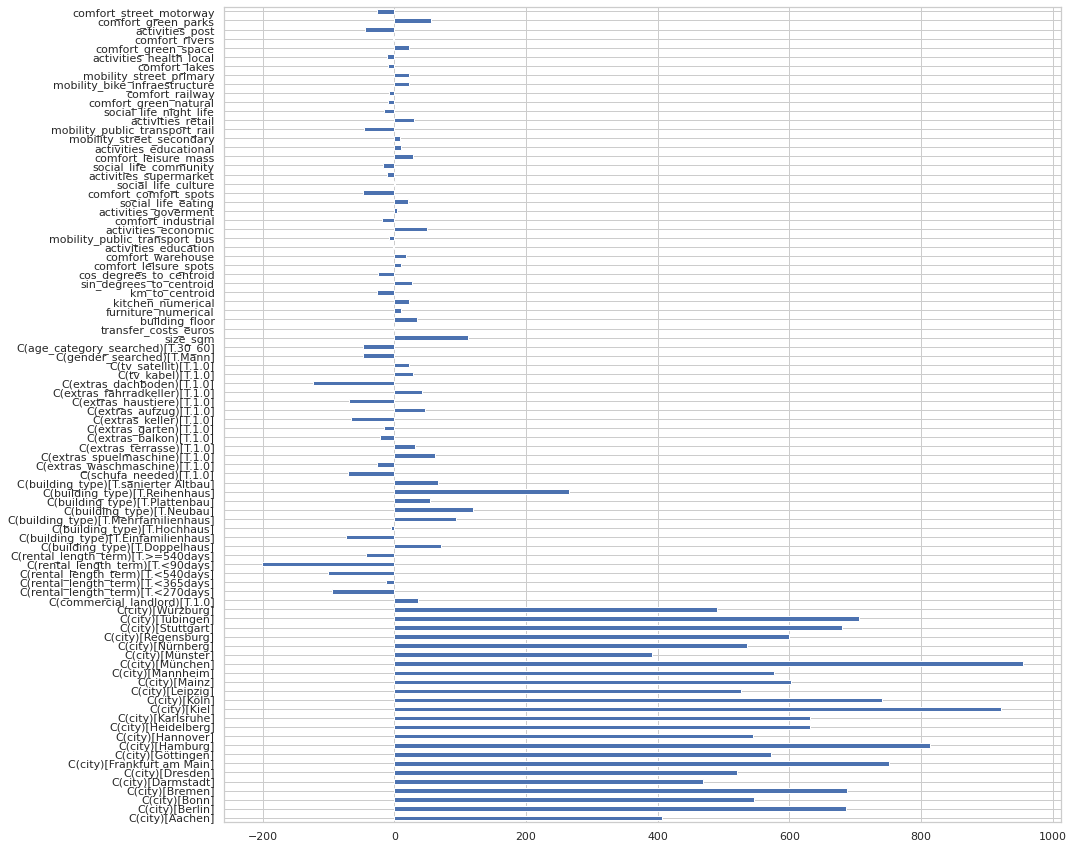

In [41]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 188.4864746993624
RMSE base model: 279.10092686185754


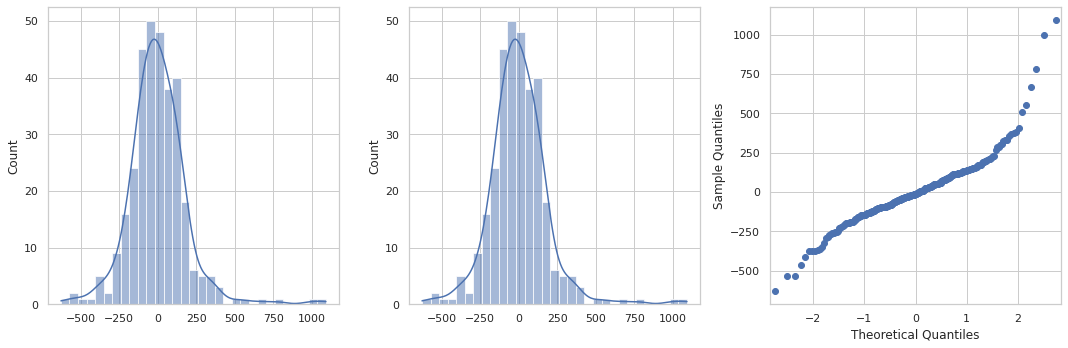

In [42]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_euros'])]*len(y_pred)
y_true = df_city['price_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

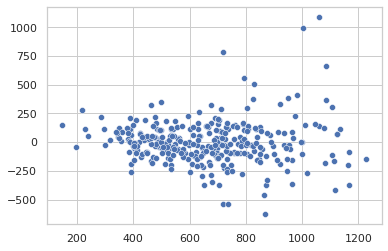

In [43]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                           p_value        coef
variable                                                      
C(city)[München]                      6.295826e-25  955.226205
C(city)[Kiel]                         4.810528e-04  921.045472
C(city)[Hamburg]                      1.748793e-14  813.822286
C(city)[Frankfurt am Main]            3.382670e-17  750.993570
C(city)[Köln]                         1.262003e-14  740.998509
C(city)[Tübingen]                     5.364007e-04  705.903575
C(city)[Bremen]                       4.118360e-07  687.863094
C(city)[Berlin]                       7.290748e-15  686.282691
C(city)[Stuttgart]                    4.717019e-11  679.276572
C(city)[Heidelberg]                   4.532393e-07  632.042695
C(city)[Karlsruhe]                    2.713238e-08  631.819407
C(city)[Mainz]                        1.222459e-06  601.808987
C(city)[Regensburg]                   3.871715e-06  600.212521
C(city)[Mannheim]                     8.059792e-08  576

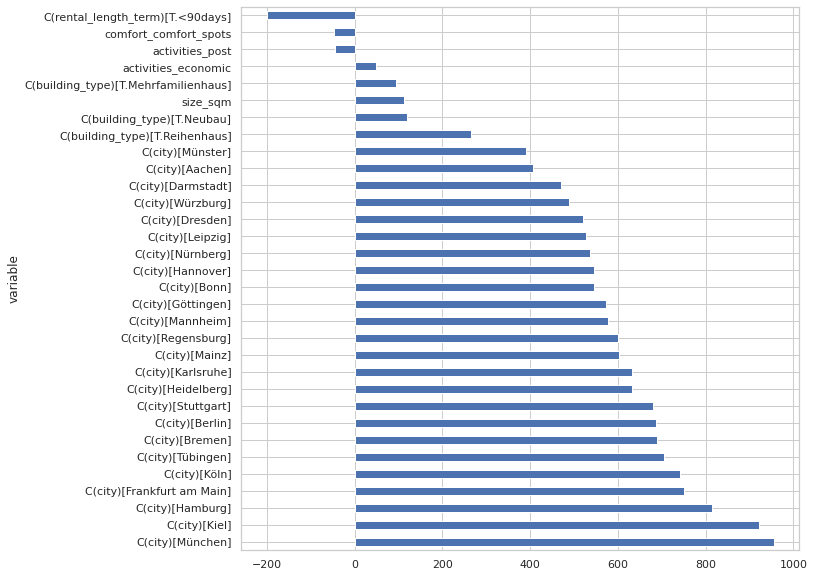

In [44]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');